In [87]:
import numpy as np
import pandas as pd 
import torch 
import matplotlib.pyplot as plt 

In [88]:
import os 
os.chdir('/kaggle/input/data-diff') #Define Data Directory

In [89]:
import torch
from torch.utils.data import Dataset
import torch.nn.functional as F
import numpy as np

class SuperresDataset(Dataset):
    def __init__(self, hr_images, lr_images, max_images=None):
        """
        Initialize the SuperresDataset.
        Parameters:
        - hr_images (numpy array): High-resolution images of shape (N, 1, 128, 128).
        - lr_images (numpy array): Low-resolution images of shape (N, 1, 64, 64).
        - max_images (int, optional): Maximum number of images to use.
        """
        self.hr_images = torch.from_numpy(self.normalize(hr_images))
        self.lr_images = torch.from_numpy(self.normalize(lr_images))
        
        if max_images is not None:
            self.hr_images = self.hr_images[:max_images]
            self.lr_images = self.lr_images[:max_images]
        
    def __len__(self):
        return len(self.hr_images)

    def __getitem__(self, idx):
        """
        Get the interpolated low-resolution image and high-resolution image at the specified index.
        Parameters:
        - idx (int): Index of the image to retrieve.
        Returns:
        - tuple of torch.Tensor: Interpolated low-resolution image and high-resolution image.
        """
        hr = self.hr_images[idx]
        lr = self.lr_images[idx]
        
        # Interpolate LR image to the size of HR image
        lr_interpolated = F.interpolate(lr.unsqueeze(0), size=(128, 128), mode='bilinear', align_corners=False)
        
        return lr_interpolated.squeeze(0), hr

    @staticmethod
    def normalize(x):
        """
        Normalize the images to [0, 1] range.
        """
        return (x - np.min(x)) / (np.max(x) - np.min(x))

In [90]:
hr_images = np.load('HR_new.npy')
lr_images = np.load('LR_new.npy')

In [91]:
import numpy as np
import torch
from torch.utils.data import DataLoader

total_samples = len(hr_images)
train_size = int(0.90 * total_samples)
test_size = total_samples - train_size
indices = np.arange(total_samples)
np.random.shuffle(indices)
train_indices, test_indices = indices[:train_size], indices[train_size:]

train_dataset = SuperresDataset([hr_images[i] for i in train_indices], [lr_images[i] for i in train_indices])
test_dataset = SuperresDataset([hr_images[i] for i in test_indices], [lr_images[i] for i in test_indices])

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [92]:
dataiter = iter(train_loader)
batch = next(dataiter)

hr_images = batch[1]
min_val = hr_images.min().item()
max_val = hr_images.max().item()

print(f"Min value: {min_val}, Max value: {max_val}")

Min value: 0.04150550812482834, Max value: 0.9489057064056396


In [93]:
import torch
import torch.nn as nn

class SRCNN(nn.Module):
    def __init__(self, num_channels=1):
        super(SRCNN, self).__init__()
        self.conv1 = nn.Conv2d(num_channels, 64, kernel_size=9, padding=4)
        self.conv2 = nn.Conv2d(64, 32, kernel_size=1)
        self.conv3 = nn.Conv2d(32, num_channels, kernel_size=5, padding=2)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.conv3(x)
        return x

# Create the model
model = SRCNN()

In [94]:
model = SRCNN()

In [95]:
import torch
from tqdm import tqdm

def train(model, train_loader, criterion, optimizer, scheduler, device, num_epochs=30):
    model.to(device)
    
    for epoch in range(num_epochs):
        model.train()  # Set the model to training mode
        
        running_loss = 0.0
        total_batches = len(train_loader)
        
        # Use tqdm for the progress bar
        pbar = tqdm(train_loader, desc=f'Epoch {epoch + 1}/{num_epochs}', leave=False)
        
        for data in pbar:
            lr, hr = data[0].to(device), data[1].to(device)  # Changed from data['lr'] to data[0] and data['hr'] to data[1]
            
            optimizer.zero_grad()
            sr = model(lr)
            loss = criterion(sr, hr)
            
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            
            # Update progress bar
            pbar.set_postfix({'loss': f'{loss.item():.8f}'})
        
        # Step the scheduler after each epoch
        scheduler.step()
        
        # Calculate average loss for the epoch
        epoch_loss = running_loss / total_batches
        
        # Print loss after each epoch
        print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {epoch_loss:.8f}')
    
    print('Finished Training')

In [96]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if torch.cuda.device_count() > 1:
    model = torch.nn.DataParallel(model)

In [97]:
from torch import optim
from torch.optim.lr_scheduler import StepLR

criteria = nn.L1Loss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
scheduler = StepLR(optimizer, step_size=20, gamma=0.1)
train(model, train_loader, criteria, optimizer, scheduler, device, num_epochs=20)

Epoch 1/20, Loss: 0.02079724


Epoch 2/20, Loss: 0.01399280


Epoch 3/20, Loss: 0.01405085


Epoch 4/20, Loss: 0.01361227


Epoch 5/20, Loss: 0.01354104


Epoch 6/20, Loss: 0.01339235


Epoch 7/20, Loss: 0.01329072


Epoch 8/20, Loss: 0.01370920


Epoch 9/20, Loss: 0.01339409


Epoch 10/20, Loss: 0.01334388


Epoch 11/20, Loss: 0.01345221


Epoch 12/20, Loss: 0.01343247


Epoch 13/20, Loss: 0.01323600


Epoch 14/20, Loss: 0.01329162


Epoch 15/20, Loss: 0.01324959


Epoch 16/20, Loss: 0.01313018


Epoch 17/20, Loss: 0.01312435


Epoch 18/20, Loss: 0.01328171


Epoch 19/20, Loss: 0.01308429


Epoch 20/20, Loss: 0.01325732
Finished Training


In [98]:
save_path = "/kaggle/working/SRCNN.pth"
torch.save(model.state_dict(), save_path)
print("Saved Successfully")

Saved Successfully


In [99]:
!pip install pytorch_msssim

In [100]:
import torch
import torch.nn as nn
from tqdm import tqdm
from pytorch_msssim import ssim
import math

def evaluate(model, test_loader, device):
    model.eval()
    mse_criterion = nn.MSELoss()
    l1_criterion = nn.L1Loss()
    
    psnr_scores = []
    ssim_scores = []
    mse_scores = []
    l1_scores = []
    
    with torch.no_grad():
        for data in tqdm(test_loader, desc="Evaluating"):
            lr, hr = data[0].to(device), data[1].to(device)
            sr = model(lr)
            
            # Ensure sr and hr have the same size
            if sr.size() != hr.size():
                sr = torch.nn.functional.interpolate(sr, size=hr.size()[2:], mode='bilinear', align_corners=False)
            
            # Calculate metrics for each image in the batch
            for i in range(sr.size(0)):
                sr_img = sr[i].unsqueeze(0)
                hr_img = hr[i].unsqueeze(0)
                
                # MSE
                mse = mse_criterion(sr_img, hr_img).item()
                mse_scores.append(mse)
                
                # PSNR
                psnr = 10 * math.log10(1 / mse)
                psnr_scores.append(psnr)
                
                # SSIM
                ssim_score = ssim(sr_img, hr_img, data_range=1.0, size_average=False).item()
                ssim_scores.append(ssim_score)
                
                # L1 Loss
                l1_loss = l1_criterion(sr_img, hr_img).item()
                l1_scores.append(l1_loss)
    
    # Calculate average scores
    avg_psnr = sum(psnr_scores) / len(psnr_scores)
    avg_ssim = sum(ssim_scores) / len(ssim_scores)
    avg_mse = sum(mse_scores) / len(mse_scores)
    avg_l1 = sum(l1_scores) / len(l1_scores)
    
    return {
        'psnr': psnr_scores,
        'ssim': ssim_scores,
        'mse': mse_scores,
        'l1': l1_scores,
        'avg_psnr': avg_psnr,
        'avg_ssim': avg_ssim,
        'avg_mse': avg_mse,
        'avg_l1': avg_l1
    }

results = evaluate(model, test_loader, device)

Evaluating: 100%|██████████| 9/9 [00:00<00:00, 18.26it/s]


In [101]:
print(len(test_loader))

9


In [102]:
print(f"Average PSNR: {results['avg_psnr']:.2f}")
print(f"Average SSIM: {results['avg_ssim']:.4f}")
print(f"Average MSE: {results['avg_mse']:.6f}")
print(f"Average L1 Loss: {results['avg_l1']:.6f}")

Average PSNR: 31.76
Average SSIM: 0.8736
Average MSE: 0.000868
Average L1 Loss: 0.022003


Input shape (lr): torch.Size([32, 1, 128, 128])
Ground truth shape (hr): torch.Size([32, 1, 128, 128])
Model output shape (sr): torch.Size([32, 1, 128, 128])
Resized model output shape (sr): torch.Size([32, 1, 128, 128])


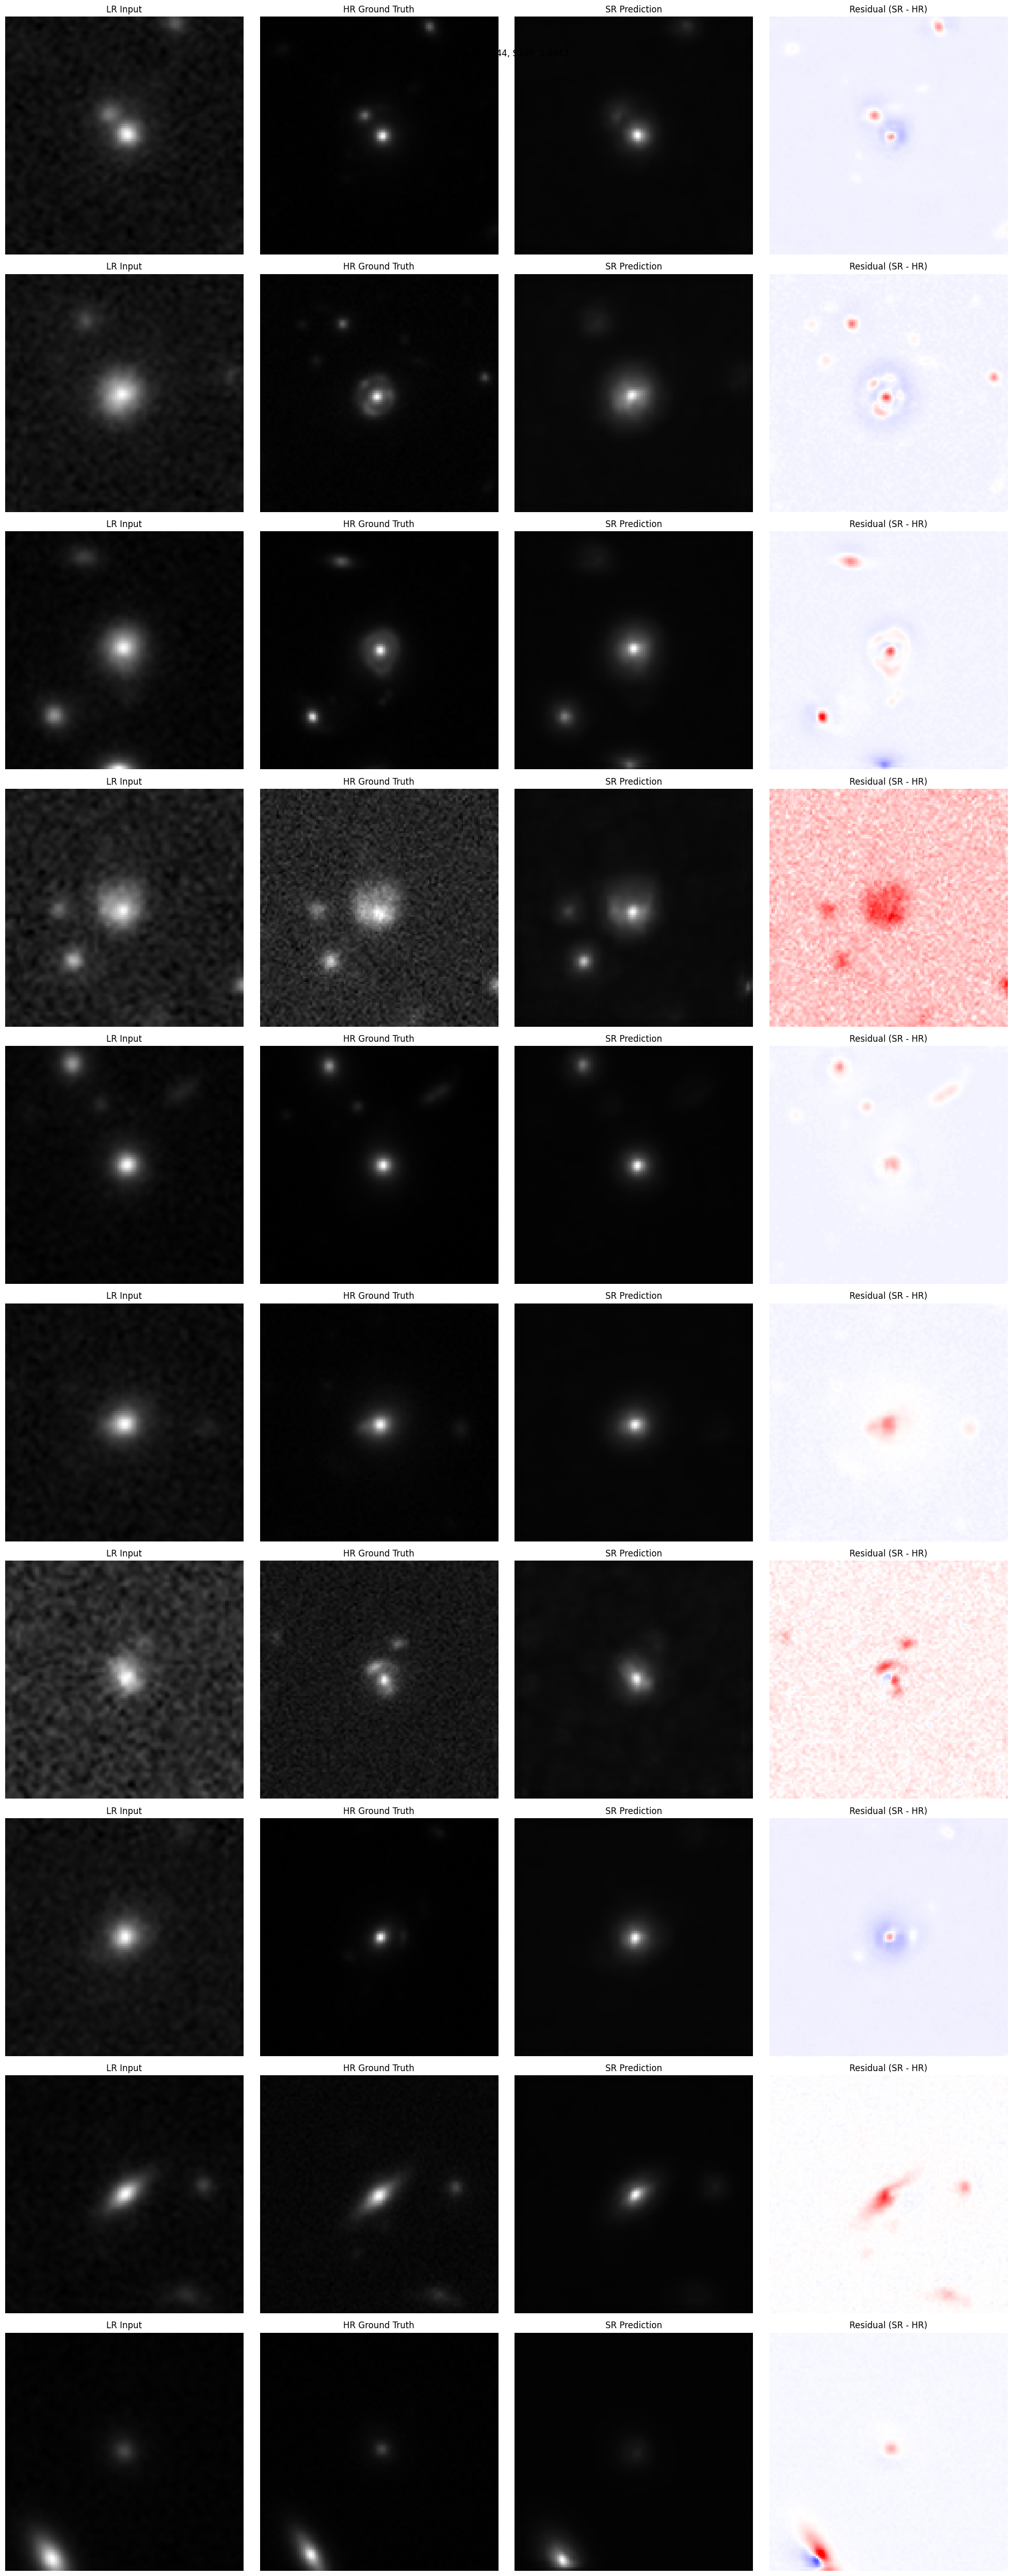

In [104]:
import matplotlib.pyplot as plt
import torch
import numpy as np
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr

def norma(x):
    return (x - x.min()) / (x.max() - x.min())

def plot_samples(model, test_loader, device, num_samples=10):
    model.eval()
    
    # Get a batch of images
    lr, hr = next(iter(test_loader))
    lr, hr = lr.to(device), hr.to(device)
    
    print(f"Input shape (lr): {lr.shape}")
    print(f"Ground truth shape (hr): {hr.shape}")
    
    with torch.no_grad():
        sr = model(lr)
    
    print(f"Model output shape (sr): {sr.shape}")
    
    # Ensure sr and hr have the same size
    if sr.size() != hr.size():
        sr = torch.nn.functional.interpolate(sr, size=hr.size()[2:], mode='bilinear', align_corners=False)
    
    print(f"Resized model output shape (sr): {sr.shape}")
    
    # Determine the number of samples to plot (minimum of batch size and num_samples)
    num_samples = min(lr.size(0), num_samples)
    
    # Calculate residuals
    residuals = hr - sr
    
    # Calculate metrics
    batch_psnr = []
    batch_ssim = []
    for i in range(num_samples):
        sr_np = norma(sr[i, 0].cpu().numpy())
        hr_np = norma(hr[i, 0].cpu().numpy())
        batch_psnr.append(psnr(hr_np, sr_np, data_range=1.0))
        batch_ssim.append(ssim(hr_np, sr_np, data_range=1.0))
    
    avg_psnr = np.mean(batch_psnr)
    avg_ssim = np.mean(batch_ssim)
    
    # Plot the images
    fig, axes = plt.subplots(num_samples, 4, figsize=(20, 5*num_samples))
    
    # Ensure axes is always 2D, even when num_samples is 1
    if num_samples == 1:
        axes = axes.reshape(1, -1)
    
    for i in range(num_samples):
        # LR image
        axes[i, 0].imshow(lr[i, 0].cpu().numpy(), cmap='gray')
        axes[i, 0].set_title('LR Input')
        axes[i, 0].axis('off')
        # HR image
        axes[i, 1].imshow(hr[i, 0].cpu().numpy(), cmap='gray')
        axes[i, 1].set_title('HR Ground Truth')
        axes[i, 1].axis('off')
        # SR prediction
        axes[i, 2].imshow(sr[i, 0].cpu().numpy(), cmap='gray')
        axes[i, 2].set_title('SR Prediction')
        axes[i, 2].axis('off')
        # Residual map
        axes[i, 3].imshow(residuals[i, 0].cpu().numpy(), cmap='bwr', vmin=-0.5, vmax=0.5)
        axes[i, 3].set_title('Residual (SR - HR)')
        axes[i, 3].axis('off')
    
    plt.tight_layout()
    plt.suptitle(f'PSNR: {avg_psnr:.4f}, SSIM: {avg_ssim:.4f}')
    plt.show()

# Usage
plot_samples(model, test_loader, device, num_samples=10)  # Requesting 10 samples
